## Notebook to test out freesufer stats output without using freesurfer utilities

In [3]:
import pandas as pd
import numpy as np
from freesurfer_stats import CorticalParcellationStats
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

In [2]:
metadata_dir = "/home/nikhil/projects/brain_changes/brain-diff/metadata/"

# DKT
ukbb_dkt_fields = f"{metadata_dir}UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = f"{metadata_dir}UKBB_DKT_CT_Fields.csv"

# ASEG
ukbb_aseg_fields = f"{metadata_dir}UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = f"{metadata_dir}UKBB_ASEG_vol_Fields.csv"


fs_output_dir = "/home/nikhil/projects/QPN_processing/test_data/fmriprep/output/freesurfer-6.0.1/"

### Read DKT CT stats

In [3]:
stat_file = "aparc.DKTatlas.stats"
stat_measure = "average_thickness_mm" 
save_dir = './'


ukbb_dkt_ct_fields_df = pd.read_csv(ukbb_dkt_ct_fields)

hemispheres = ["lh", "rh"]
roi_ct_field_df_dict = {}

subject_id_list = ["sub-PD01369D713546","sub-NIMHANS001"]

hemi_stat_measures_dict = {}
for hemi in hemispheres:
    stat_measure_df = pd.DataFrame()
    for subject_id in subject_id_list:
        fs_stats_dir = f"{fs_output_dir}{subject_id}/stats/"
        stats = CorticalParcellationStats.read(f"{fs_stats_dir}{hemi}.{stat_file}").structural_measurements
        
        cols = ["subject_id"] + list(stats["structure_name"].values)
        vals = [subject_id] + list(stats[stat_measure].values)
        
        df = pd.DataFrame(columns=cols)
        df.loc[0] = vals
        stat_measure_df = pd.concat([stat_measure_df, df], axis=0)

    # replace columns names with ukbb field IDs
    roi_ct_field_df = ukbb_dkt_ct_fields_df[ukbb_dkt_ct_fields_df["hemi"]==hemi][["Field ID","roi"]]
    roi_ct_field_df["hemi"] = hemi
    roi_ct_field_id_dict = dict(zip(roi_ct_field_df["roi"], roi_ct_field_df["Field ID"]))
    stat_measure_df = stat_measure_df.rename(columns=roi_ct_field_id_dict)
    
    hemi_stat_measures_dict[hemi] = stat_measure_df

    roi_ct_field_df_dict[hemi] = roi_ct_field_df

# merge left and right dfs
stat_measure_LR_df = pd.merge(hemi_stat_measures_dict["lh"],hemi_stat_measures_dict["rh"], on="subject_id")

save_file = f"{stat_file.split('.')[1]}_{stat_measure.rsplit('_',1)[0]}.csv"

print(f"Saving stat measures here: {save_dir}/{save_file}")
stat_measure_LR_df.to_csv(f"{save_dir}/{save_file}")


Saving stat measures here: .//DKTatlas_average_thickness.csv


### Read ASEG vol stats

In [4]:
def parse_aseg(aseg_file, stat_measure):
    aseg_data = np.loadtxt(aseg_file, dtype="i1,i1,i4,f4,S32,f4,f4,f4,f4,f4")

    aseg_df = pd.DataFrame(data=aseg_data)
    aseg_df = aseg_df[["f4","f3"]].rename(columns={"f3":stat_measure, "f4":"hemi_ROI"})
    aseg_df["hemi_ROI"] = aseg_df["hemi_ROI"].str.decode('utf-8') 

    print(f"number of ROIs in aseg file: {len(aseg_df)}")

    return aseg_df


In [5]:
stat_file = "aseg.stats"
stat_measure = "Volume_mm3"

stat_measure_df = pd.DataFrame()
for subject_id in subject_id_list:
    fs_stats_dir = f"{fs_output_dir}{subject_id}/stats/"
    aseg_file = f"{fs_stats_dir}{stat_file}"
    stats = parse_aseg(aseg_file,stat_measure)
    
    cols = ["subject_id"] + list(stats["hemi_ROI"].values)
    vals = [subject_id] + list(stats[stat_measure].values)
    
    df = pd.DataFrame(columns=cols)
    df.loc[0] = vals
    stat_measure_df = pd.concat([stat_measure_df, df], axis=0)

# Grab UKBB field ids lookup table
ukbb_aseg_vol_fields_df = pd.read_csv(ukbb_aseg_vol_fields)

roi_vol_field_df = ukbb_aseg_vol_fields_df[ukbb_aseg_vol_fields_df["hemi_ROI"].isin(stat_measure_df.columns)]
common_rois = list(roi_vol_field_df["hemi_ROI"].values)
roi_vol_field_id_dict = dict(zip(roi_vol_field_df["hemi_ROI"], roi_vol_field_df["Field ID"]))

print(f"Number of aseg vol ROIs after UKBB merge: {len(roi_vol_field_id_dict)}")

# Rename ROIs with ukbb ids (remove the ROIs which don't have ukbb ids)
stat_measure_df = stat_measure_df[["subject_id"] + common_rois].copy()
stat_measure_df = stat_measure_df.rename(columns=roi_vol_field_id_dict)

save_file = f"aseg_subcortical_volumes.csv"

print(f"Saving stat measures here: {save_dir}/{save_file}")
stat_measure_df.to_csv(f"{save_dir}/{save_file}")


number of ROIs in aseg file: 45
number of ROIs in aseg file: 45
Number of aseg vol ROIs after UKBB merge: 36
Saving stat measures here: .//aseg_subcortical_volumes.csv


### DKT + ASEG columns --> UKBB ID list
- This is list of input variable for UKBB and ADNI comparison

In [6]:
# aseg_ukbb_ids_df = roi_vol_field_df[["Field ID","hemi_ROI"]].copy()
# aseg_ukbb_ids_df["stat"] = "aseg"

# dkt_ukbb_ids_df = pd.concat([roi_ct_field_df_dict["lh"],roi_ct_field_df_dict["rh"]],axis=0)
# dkt_ukbb_ids_df["hemi_ROI"] = dkt_ukbb_ids_df["hemi"] + "-" + dkt_ukbb_ids_df["roi"]
# dkt_ukbb_ids_df["stat"] = "DKT"

# brainage_fs_ukbb_field_ids_df = pd.concat([dkt_ukbb_ids_df[["Field ID","hemi_ROI","stat"]], 
#                                             aseg_ukbb_ids_df[["Field ID","hemi_ROI","stat"]]],axis=0)


# brainage_fs_ukbb_field_ids_df.to_csv(f"{metadata_dir}/brainage_fs_ukbb_field_ids.csv")

# brainage_fs_ukbb_field_ids_df.head()

,Field ID,hemi_ROI,stat
0,27174,lh-caudalanteriorcingulate,DKT
2,27175,lh-caudalmiddlefrontal,DKT
4,27176,lh-cuneus,DKT
6,27177,lh-entorhinal,DKT
8,27178,lh-fusiform,DKT


## Plot CT after collating stats

Desikan-Killiany-Tourville Atlas
Cortical Regions. Frontal pole, temporal pole, and “banks of the superior temporal sulcus” regions were removed as per the DKT protocol, 

In [7]:
data_dir = "/home/nikhil/projects/brain_changes/data/"
metadata_dir = f"{data_dir}adni/metadata"

adnimerge = f"{metadata_dir}/ADNIMERGE.csv"

FS_stats_dir = f"{data_dir}adni/freesurfer/"
BL_CT_file = f"{FS_stats_dir}adni2_bl/DKTatlas_average_thickness.csv"
BL_ASEG_file = f"{FS_stats_dir}adni2_bl/aseg_subcortical_volumes.csv"
FU_CT_file = f"{FS_stats_dir}m24/DKTatlas_average_thickness.csv"
FU_ASEG_file = f"{FS_stats_dir}m24/aseg_subcortical_volumes.csv"

In [8]:
BL_CT_df = pd.read_csv(BL_CT_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")
BL_ASEG_df = pd.read_csv(BL_ASEG_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")
FU_CT_df = pd.read_csv(FU_CT_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")
FU_ASEG_df = pd.read_csv(FU_ASEG_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")


print(f"Number of BL, CT subjects: {len(BL_CT_df)}, number of ROIs: 2 x {len(BL_CT_df.columns)/2}")
print(f"Number of BL, ASEG subjects: {len(BL_ASEG_df)}, number of ROIs: {len(BL_ASEG_df.columns)}")

print(f"Number of FU, CT subjects: {len(FU_CT_df)}, number of ROIs: 2 x {len(FU_CT_df.columns)/2}")
print(f"Number of FU, ASEG subjects: {len(FU_ASEG_df)}, number of ROIs: {len(FU_ASEG_df.columns)}")

## Ensures the visit has both DKT and ASEG data
BL_subjects = set(BL_CT_df.index) & set(BL_ASEG_df.index)
FU_subjects = set(FU_CT_df.index) & set(FU_ASEG_df.index)

BL_and_FU_subjects = list(BL_subjects & FU_subjects)

## Some outlier that need to be looked at (most likely proc failures)
drop_subjects = ["sub-ADNI082S4244"] #sub-ADNI082S4244 --> super low inter-visit correlation

for ds in drop_subjects:
    BL_and_FU_subjects.remove(ds)

print(f"Number unique subjects with CT and ASEG features\n BL: {len(BL_subjects)}, \
FU: {len(FU_subjects)}, dropped subjects: {len(drop_subjects)}, BLandFU: {len(BL_and_FU_subjects)}")

Number of BL, CT subjects: 202, number of ROIs: 2 x 31.0
Number of BL, ASEG subjects: 201, number of ROIs: 36
Number of FU, CT subjects: 616, number of ROIs: 2 x 31.0
Number of FU, ASEG subjects: 615, number of ROIs: 36
Number unique subjects with CT and ASEG features
 BL: 201, FU: 615, dropped subjects: 1, BLandFU: 102


In [9]:
adnimerge_df = pd.read_csv(adnimerge)
print(f"ADNIMERGE len: {len(adnimerge_df)}")

adnimerge_df["subject_id"] = "sub-ADNI" + adnimerge_df["PTID"]
adnimerge_df["subject_id"] = adnimerge_df["subject_id"].str.replace("_","")

useful_cols = ["subject_id","DX_bl","AGE","PTGENDER","VISCODE"]
adnimerge_dx_df = adnimerge_df[(adnimerge_df["subject_id"].isin(BL_and_FU_subjects)) & (adnimerge_df["VISCODE"]=="bl")][useful_cols]

print(f"adnimerge with longitudinal subjects. n_subjects = {len(adnimerge_dx_df)}")
adnimerge_dx_df.head()

ADNIMERGE len: 11483
adnimerge with longitudinal subjects. n_subjects = 102


,subject_id,DX_bl,AGE,PTGENDER,VISCODE
3406,sub-ADNI072S4007,EMCI,78.1,Male,bl
3426,sub-ADNI012S4026,CN,73.5,Male,bl
3439,sub-ADNI031S4032,CN,70.2,Female,bl
3448,sub-ADNI941S4036,EMCI,74.0,Male,bl
3472,sub-ADNI067S4054,EMCI,68.3,Female,bl


In [10]:
BL_CT_df_subset = BL_CT_df.loc[BL_and_FU_subjects].copy()

FU_CT_df_subset = FU_CT_df.loc[BL_and_FU_subjects].copy()

CT_diff_df = BL_CT_df_subset - FU_CT_df_subset
print(f"Number of subjects with two visit data: {len(CT_diff_df)}")

CT_diff_df = pd.merge(CT_diff_df.reset_index(), adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")

CT_diff_df.head()

Number of subjects with two visit data: 102


,subject_id,27174,27175,27176,27177,27178,27179,27180,27181,27182,...,27289,27290,27291,27292,27293,27294,27295,27296,27297,DX_bl
0,sub-ADNI130S4417,-0.029,-0.023,-0.059,-0.103,-0.008,-0.011,0.007,0.080,-0.063,...,-0.049,0.054,-0.045,-0.050,0.024,0.098,0.040,0.085,0.083,EMCI
1,sub-ADNI082S4208,0.026,0.052,-0.004,0.033,0.036,0.011,0.024,0.101,0.029,...,-0.013,-0.093,0.056,0.037,0.045,0.074,0.026,0.258,0.127,CN
2,sub-ADNI031S4032,0.040,-0.106,-0.010,-0.189,-0.087,0.016,0.000,-0.168,0.010,...,-0.001,0.188,0.018,0.044,0.029,-0.071,-0.023,-0.115,-0.039,CN
3,sub-ADNI072S4539,-0.176,0.135,-0.004,0.125,-0.054,0.065,0.044,0.077,0.022,...,0.015,-0.060,0.032,0.143,0.043,0.054,-0.009,0.078,0.042,EMCI
4,sub-ADNI022S4320,-0.056,0.019,0.001,0.131,-0.018,0.048,-0.147,-0.001,0.064,...,0.095,-0.083,0.005,-0.017,-0.018,0.039,-0.010,-0.011,-0.078,CN


### Save available adni longitudinal data into single CSV

In [17]:
# adni_FS_DKT_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_DKT.csv"
# adni_FS_aseg_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_aseg.csv"

# # DKT (CT)
# BL_CT_df_subset = BL_CT_df.loc[BL_and_FU_subjects].copy()
# FU_CT_df_subset = FU_CT_df.loc[BL_and_FU_subjects].copy()

# CT_cols = BL_CT_df_subset.columns
# CT_cols_ses2 = list(CT_cols.astype(str) + "-2.0")
# CT_cols_ses3 = list(CT_cols.astype(str) + "-3.0")

# BL_CT_df_subset = BL_CT_df_subset.rename(columns=dict(zip(CT_cols,CT_cols_ses2)))
# FU_CT_df_subset = FU_CT_df_subset.rename(columns=dict(zip(CT_cols,CT_cols_ses3)))

# CT_subset_df = pd.concat([BL_CT_df_subset,FU_CT_df_subset],axis=1)
# CT_subset_df.to_csv(adni_FS_DKT_csv)

# # ASEG (vol)
# BL_ASEG_df_subset = BL_ASEG_df.loc[BL_and_FU_subjects].copy()
# FU_ASEG_df_subset = FU_ASEG_df.loc[BL_and_FU_subjects].copy()

# aseg_cols = BL_ASEG_df_subset.columns
# aseg_cols_ses2 = list(aseg_cols.astype(str) + "-2.0")
# aseg_cols_ses3 = list(aseg_cols.astype(str) + "-3.0")

# BL_ASEG_df_subset = BL_ASEG_df_subset.rename(columns=dict(zip(aseg_cols,aseg_cols_ses2)))
# FU_ASEG_df_subset = FU_ASEG_df_subset.rename(columns=dict(zip(aseg_cols,aseg_cols_ses3)))

# ASEG_subset_df = pd.concat([BL_ASEG_df_subset,FU_ASEG_df_subset],axis=1)
# ASEG_subset_df.to_csv(adni_FS_aseg_csv)

### Subject specific stats

In [114]:
CT_diff_df = BL_CT_df_subset - FU_CT_df_subset
CT_avg_diff_df = CT_diff_df.mean(axis=1)
CT_avg_diff_df = pd.merge(CT_avg_diff_df.reset_index(), adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
CT_avg_diff_df = CT_avg_diff_df.rename(columns={0:"avg_change_in_CT"})

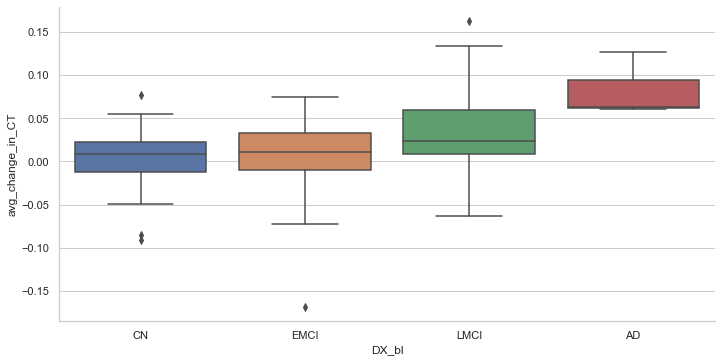

In [115]:
plot_df = CT_avg_diff_df.copy()
x_order = ["CN","EMCI","LMCI","AD"]
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="DX_bl",y="avg_change_in_CT",order=x_order,kind="box",aspect=2,data=plot_df)

### ROI specific stats

In [117]:
CT_diff_df = BL_CT_df_subset - FU_CT_df_subset
CT_diff_df = pd.merge(CT_diff_df.reset_index(), adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
CT_diff_df_melt = CT_diff_df.melt(
    id_vars=["subject_id","DX_bl"],
    var_name="ROI", 
    value_name="CT",
)
CT_diff_df_melt.head()

,subject_id,DX_bl,ROI,CT
0,sub-ADNI018S4809,EMCI,27174,-0.203
1,sub-ADNI082S4208,CN,27174,0.026
2,sub-ADNI041S4200,CN,27174,-0.066
3,sub-ADNI037S4410,CN,27174,0.064
4,sub-ADNI041S4876,EMCI,27174,0.078


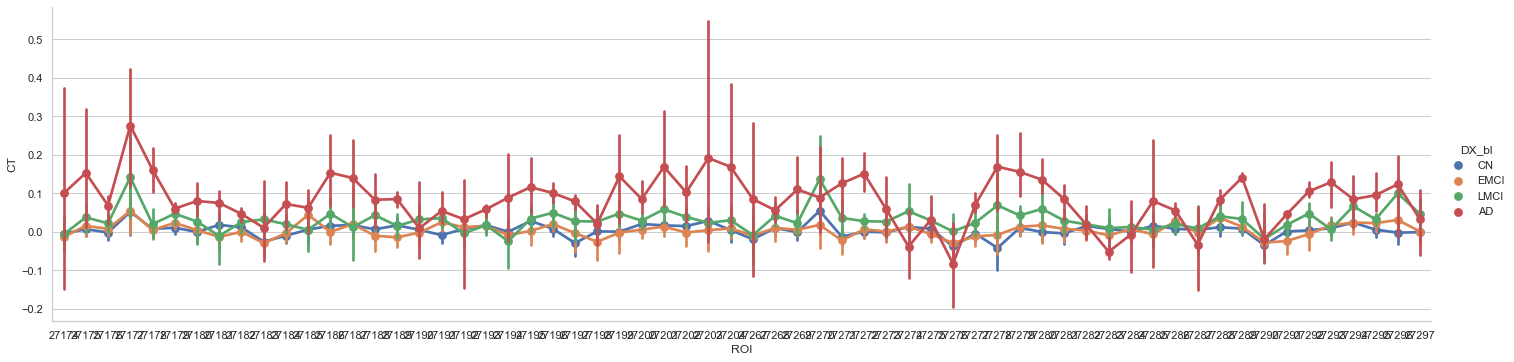

In [118]:
plot_df = CT_diff_df_melt.copy()
hue_order = ["CN","EMCI","LMCI","AD"]
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="ROI",y="CT",kind="point",hue="DX_bl",hue_order=hue_order, aspect=4,data=plot_df)

## timepoint correlation

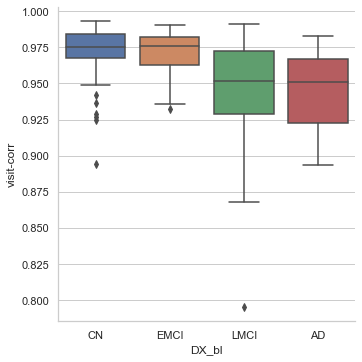

In [119]:
corr_df = BL_CT_df_subset.corrwith(FU_CT_df_subset,axis=1)

corr_df = pd.merge(corr_df.reset_index(), adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
corr_df = corr_df.rename(columns={0:"visit-corr"})

hue_order = ["CN","EMCI","LMCI","AD"]

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="visit-corr",x="DX_bl", kind="box", order=hue_order, data=corr_df)
    

## Read UKBB fields 
- This is based on UKBB showcase
- Only doing once and saving fieldIDs-ROIs csv

### DKT CT 

In [ ]:
ukbb_dkt_fields_df = pd.read_csv(ukbb_dkt_fields)
ukbb_dkt_fields_df.head()

### Grab rows with specific stat measure of interest

In [ ]:
stat_measure = "Mean thickness" 
ukbb_dkt_measure_df = ukbb_dkt_fields_df[ukbb_dkt_fields_df["Description"].str.startswith(stat_measure)].copy()
ukbb_dkt_measure_df["Description"] = ukbb_dkt_measure_df["Description"].str.replace("Mean thickness","Mean_thickness")
print(f"number of fields with {stat_measure}: {len(ukbb_dkt_measure_df)}")

ukbb_dkt_measure_df[["metric","roi","hemi"]] = ukbb_dkt_measure_df["Description"].str.split(" ", expand=True)[[0,2,3]]
ukbb_dkt_measure_df["hemi"] = ukbb_dkt_measure_df["hemi"].replace({"(left":"lh", "(right":"rh"})
ukbb_dkt_measure_df.head()

In [ ]:
## Save 
# UKBB_dkt_ct_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_DKT_CT_Fields.csv"
# ukbb_dkt_measure_df.to_csv(UKBB_dkt_ct_fields)

### ASEG Vols

In [ ]:
ukbb_aseg_fields_df = pd.read_csv(ukbb_aseg_fields)
print(f"Number of fields: {len(ukbb_aseg_fields_df)}")
ukbb_aseg_fields_df.head()

### Grab rows with specific stat measure of interest

In [ ]:
stat_measure = "Volume of" 
ukbb_aseg_fields_df = ukbb_aseg_fields_df[ukbb_aseg_fields_df["Description"].str.startswith(stat_measure)].copy()
ukbb_aseg_fields_df["Description"] = ukbb_aseg_fields_df["Description"].str.replace("Mean thickness","Mean_thickness")
print(f"number of fields with {stat_measure}: {len(ukbb_aseg_fields_df)}")

ukbb_aseg_fields_df.head()

In [ ]:
ukbb_aseg_fields_df[["metric","roi","hemi"]] = ukbb_aseg_fields_df["Description"].str.split(" ", expand=True)[[0,2,3]]
ukbb_aseg_fields_df["hemi"] = ukbb_aseg_fields_df["hemi"].replace({"(left":"Left-", "(right":"Right-", "(whole":""})
ukbb_aseg_fields_df["hemi_ROI"] = ukbb_aseg_fields_df["hemi"] + ukbb_aseg_fields_df["roi"]
ukbb_aseg_fields_df.head()

In [ ]:
# # Save 
# ukbb_aseg_vol_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_ASEG_vol_Fields.csv"
# ukbb_aseg_fields_df.to_csv(ukbb_aseg_vol_fields)